In [6]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
from statistics import median
from rsi import apply as rsi

from envs import SimpleTradingEnvironment
from agent import DQNAgent
from utils import get_scaler

In [11]:
# Generate data like a sine wave data
Fs = 2000
f = 5
x = np.arange(1000)
data = np.sin(2 * np.pi * f * x / Fs)

In [12]:
price_data = pd.DataFrame(data, columns=['price'])
price_data['price'] = (price_data['price'] * 100) + 300

# Add column for RSI to use as a feature for learning
price_data['rsi'] = rsi(price_data['price'])

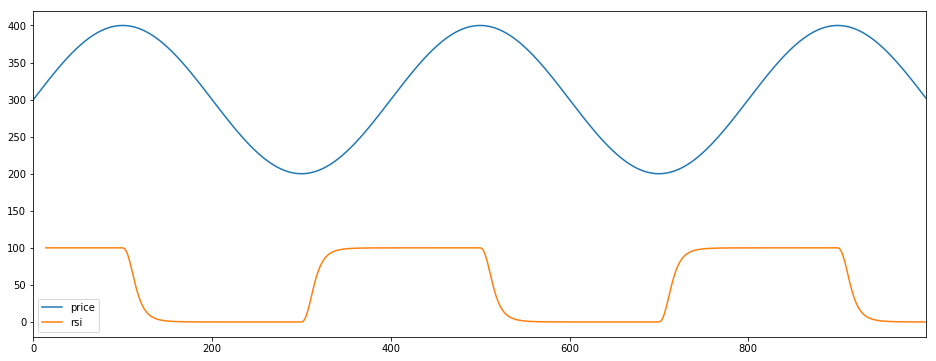

In [13]:
price_data.plot(figsize=(16,6))

In [14]:
train_size = round(len(price_data)/3*2)
train_data = price_data[:train_size].copy()
test_data = price_data[train_size:].copy()
print('train size {0}, test size {1}'.format(len(train_data), len(test_data)))

train size 667, test size 333


In [15]:
episode=2000
batch_size=2
initial_invest=20000

In [22]:
env = SimpleTradingEnvironment(train_data)
state_size = env.observation_space.shape
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
scaler = get_scaler(env)
train_results = pd.DataFrame()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 32)                64        
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 99        
Total params: 1,219
Trainable params: 1,219
Non-trainable params: 0
_________________________________________________________________
None


## Train

In [23]:
for e in range(episode):
    state = env.reset()
    state = scaler.transform([state])    
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(".", end='')
            if (e + 1) % 20 == 0:
                print("")
                print("episode: {}/{}, median profit so far: {}".format(
                    e + 1, episode, median(train_results['value'].tolist())))
            train_results = train_results.append(env._stats(), ignore_index=True)
            break
        if len(agent.memory) > batch_size:
            print(agent.memory)
            print('####')
            print(batch_size)
            agent.replay(batch_size)
    if (e + 1) % 10 == 0:
        agent.save('weights/{}-dqn.h5'.format(time.strftime('%Y%m%d%H%M')))

deque([(array([[-0.995, -1.   , -0.94 ]]), 1, 0.0, array([[-0.995     , -1.        , -0.93968585]]), False), (array([[-0.995     , -1.        , -0.93968585]]), 0, 0.0, array([[-1.        , -1.        , -0.93937178]]), False), (array([[-1.        , -1.        , -0.93937178]]), 1, -1.5695691631514705, array([[-0.995     , -1.00031391, -0.93905787]]), False)], maxlen=2000)
####
2


ValueError: Error when checking input: expected dense_7_input to have shape (1,) but got array with shape (3,)

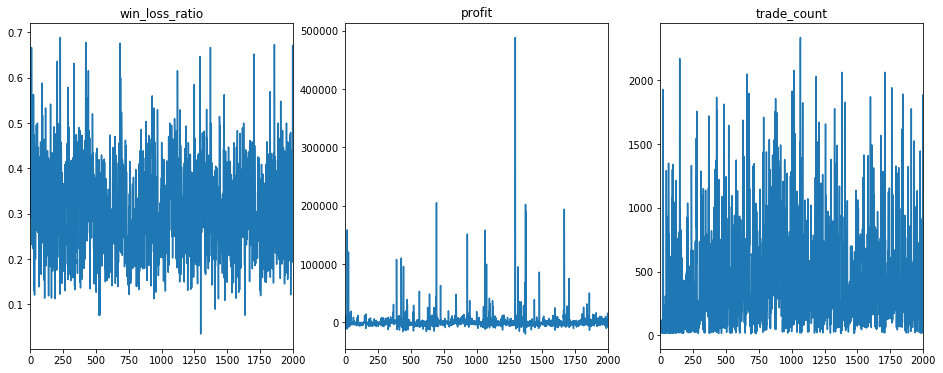

In [6]:
train_results['profit'] = train_results['value'] - initial_invest
columns_to_plot = ['win_loss_ratio', 'profit', 'trade_count']
fig, axes = plt.subplots(nrows=1,ncols=len(columns_to_plot), figsize=(16,6))
for i in range(len(columns_to_plot)):
    axes[i].title.set_text(columns_to_plot[i])
    train_results[columns_to_plot[i]].plot(ax=axes[i], subplots=True)
plt.show()

## Test

In [7]:
state_size = env.observation_space.shape
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
scaler = get_scaler(env)
test_portfolio_value = []

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                128       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 99        
Total params: 1,283
Trainable params: 1,283
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
# remake the env with test data
env = TradingEnv(test_data, initial_invest)
# load trained weights from latest saved
latest_weights_file = max(glob.glob('weights/*.h5'), key=os.path.getctime)
print('loading weights file: {0}'.format(latest_weights_file))
agent.load(latest_weights_file)
test_results = pd.DataFrame()

loading weights file: weights/201912090525-dqn.h5


In [9]:
for e in range(episode):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
        if done:
            test_results = test_results.append(env._stats(), ignore_index=True)
            break

In [10]:
test_results['profit'] = test_results['value'] - initial_invest

In [11]:
print('Median profit: {0} ({1}%)'.format(
    test_results['profit'].median(),
    test_results['profit'].median() / initial_invest * 100
))

Median profit: -3281.0 (-16.405%)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1319aeb50>]],
      dtype=object)

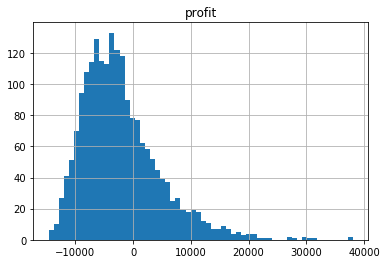

In [12]:
test_results.hist(column='profit', bins=60)